References
- https://machinelearningmastery.com/the-transformer-model/
- https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras

In [1]:
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 72.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorfl

In [2]:
import tensorflow as tf
print(tf.__version__) # use 2.10.0

SEED = 42

2.10.0


## Prepare Dataset

References:
- https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

In [3]:
!wget -P data https://raw.githubusercontent.com/jbrownlee/Datasets/master/deu.txt

--2023-04-08 14:39:33--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/deu.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11303014 (11M) [text/plain]
Saving to: ‘data/deu.txt’

deu.txt             100%[===================>]  10.78M  --.-KB/s    in 0.04s   

2023-04-08 14:39:34 (264 MB/s) - ‘data/deu.txt’ saved [11303014/11303014]



In [4]:
import string
import re
import pickle
import unicodedata
import numpy as np

# from pickle import dump
# from unicodedata import normalize
# from numpy import array
 
# load doc into memory
def load_doc(filename):
 # open the file as read only
 file = open(filename, mode='rt', encoding='utf-8')
 # read all text
 text = file.read()
 # close the file
 file.close()
 return text
 
# split a loaded document into sentences
def to_pairs(doc):
 lines = doc.strip().split('\n')
 pairs = [line.split('\t') for line in  lines]
 return pairs
 
# clean a list of lines
def clean_pairs(lines):
 cleaned = list()
 # prepare regex for char filtering
 re_print = re.compile('[^%s]' % re.escape(string.printable))
 # prepare translation table for removing punctuation
 table = str.maketrans('', '', string.punctuation)
 for pair in lines:
  clean_pair = list()
  for line in pair:
    # normalize unicode characters
    line = unicodedata.normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    # tokenize on white space
    line = line.split()
    # convert to lowercase
    line = [word.lower() for word in line]
    # remove punctuation from each token
    line = [word.translate(table) for word in line]
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    # remove tokens with numbers in them
    line = [word for word in line if word.isalpha()]
    # store as string
    clean_pair.append(' '.join(line))
  cleaned.append(clean_pair)
 return np.array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
 pickle.dump(sentences, open(filename, 'wb'))
 print('Saved: %s' % filename)
 
# load dataset
filename = 'data/deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
 print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-german.pkl
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[hello] => [hallo]
[i try] => [ich probiere es]
[i won] => [ich hab gewonnen]
[i won] => [ich habe gewonnen]
[smile] => [lacheln]
[cheers] => [zum wohl]
[freeze] => [keine bewegung]
[freeze] => [stehenbleiben]
[got it] => [verstanden]
[got it] => [einverstanden]
[he ran] => [er rannte]
[he ran] => [er lief]
[hop in] => [mach mit]
[hug me] => [druck mich]
[hug me] => [nimm mich in den arm]
[hug me] => [umarme mich]
[i fell] => [ich fiel]
[i fell] => [ich fiel hin]
[i fell] => [ich sturzte]
[i fell] => [ich bin hingefallen]
[i fell] => [ich bin gesturzt]
[i know] => [ich wei]
[i lied] => [ich habe gelogen]
[i lost] => [ich habe verloren]
[im] => [ich bin jahre alt]
[im] => [ich bin]
[im ok] => [mir gehts gut]
[im ok] => [es geht mir gut]
[no way] => [unmoglich]
[no way] => [da

In [5]:
import pickle
import numpy as np
# from pickle import load
# from pickle import dump
# from numpy.random import rand
# from numpy.random import shuffle
 
# load a clean dataset
def load_clean_sentences(filename):
 return pickle.load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
 pickle.dump(sentences, open(filename, 'wb'))
 print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')
 
# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
np.random.shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl


## Attention

https://machinelearningmastery.com/how-to-implement-scaled-dot-product-attention-from-scratch-in-tensorflow-and-keras
https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras

In [6]:
import tensorflow as tf
# from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
# from tensorflow.keras.layers import Dense, Layer
# from keras.backend import softmax

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(d_k, tf.float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = tf.keras.activations.softmax(scores)

        # Computing the attention by a weighted sum of the value vectors
        return tf.matmul(weights, values)

# Implementing the Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = tf.keras.layers.Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = tf.keras.layers.Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = tf.keras.layers.Dense(d_v)  # Learned projection matrix for the values
        self.W_o = tf.keras.layers.Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1)
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], heads, -1))
            x = tf.transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = tf.transpose(x, perm=(0, 2, 1, 3))
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

### Testing Out the Code

#### Scaled Dot-Product Attention

In [7]:
import numpy as np

np.random.seed(SEED)
 
input_seq_length = 5  # Maximum length of the input sequence
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
batch_size = 64  # Batch size from the training process
 
# Dummy Data
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))

print('Q shape:', queries.shape)
print('K shape:', keys.shape)
print('V shape:', values.shape)

attention = DotProductAttention()
dot_product_attention_output = attention(queries, keys, values, d_k)
print('Dot Product Attention Output shape:', dot_product_attention_output.shape)
print(dot_product_attention_output)

Q shape: (64, 5, 64)
K shape: (64, 5, 64)
V shape: (64, 5, 64)
Dot Product Attention Output shape: (64, 5, 64)
tf.Tensor(
[[[0.42829984 0.5291363  0.48467717 ... 0.60236526 0.63144374 0.36796492]
  [0.42059597 0.51898783 0.46809804 ... 0.5975176  0.63140476 0.3960448 ]
  [0.4529177  0.5337295  0.48221606 ... 0.5861657  0.6170543  0.35611778]
  [0.43538862 0.52972203 0.47826144 ... 0.5917442  0.62593013 0.36665624]
  [0.4299884  0.5189111  0.48113105 ... 0.610327   0.6304484  0.39192218]]

 [[0.61051536 0.50249517 0.40130407 ... 0.71487737 0.36341456 0.55124193]
  [0.58420074 0.5239525  0.43119103 ... 0.7233551  0.3600105  0.56975734]
  [0.5644941  0.559814   0.44120133 ... 0.6975892  0.34060013 0.5714755 ]
  [0.5878387  0.5212065  0.4227584  ... 0.7043989  0.34812245 0.556117  ]
  [0.588035   0.52016133 0.4339036  ... 0.70503277 0.35547626 0.56170976]]

 [[0.42078587 0.49814874 0.49267098 ... 0.49847668 0.49838424 0.24419653]
  [0.41555586 0.49712974 0.49442887 ... 0.5093837  0.5085627

#### Multi-Head Attention

In [8]:
import numpy as np
# from numpy import random
 
np.random.seed(SEED)

input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of the model sub-layers' outputs
batch_size = 64  # Batch size from the training process
 
# Dummy Data
queries = np.random.random((batch_size, input_seq_length, d_k))
keys = np.random.random((batch_size, input_seq_length, d_k))
values = np.random.random((batch_size, input_seq_length, d_v))
 
print('Q shape:', queries.shape)
print('K shape:', keys.shape)
print('V shape:', values.shape)

multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
multihead_attention_output = multihead_attention(queries, keys, values)
print('Multi-Head Attention Output shape:', multihead_attention_output.shape)
print(multihead_attention_output)

Q shape: (64, 5, 64)
K shape: (64, 5, 64)
V shape: (64, 5, 64)
Multi-Head Attention Output shape: (64, 5, 512)
tf.Tensor(
[[[-0.30299643  0.23394775 -0.4088634  ...  0.47636902 -0.15791465
    0.05497486]
  [-0.2990793   0.23184803 -0.40481085 ...  0.47724223 -0.15395539
    0.04928409]
  [-0.29678386  0.23114206 -0.4068592  ...  0.47853422 -0.1538449
    0.05036146]
  [-0.29952818  0.23183464 -0.40686136 ...  0.47619727 -0.15336587
    0.05158652]
  [-0.29769224  0.23575453 -0.4049396  ...  0.4744885  -0.15592404
    0.04486067]]

 [[-0.23404859  0.12571804 -0.32508314 ...  0.48344702 -0.07852522
    0.14723861]
  [-0.2346316   0.12857246 -0.32037985 ...  0.47764283 -0.07956061
    0.14308971]
  [-0.23490886  0.12831548 -0.3215336  ...  0.48025027 -0.07520457
    0.15051557]
  [-0.23372158  0.1259031  -0.3238682  ...  0.48053494 -0.07912095
    0.14440097]
  [-0.23755684  0.12594537 -0.3240214  ...  0.48176295 -0.0770686
    0.14989807]]

 [[-0.14836578  0.1022377  -0.4228383  ...  0.

## Positional Encoding

https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1
https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/

In [9]:
# Positional Encoding
import tensorflow as tf
# from tensorflow import convert_to_tensor, string
# from tensorflow.keras.layers import TextVectorization, Embedding, Layer
# from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

class PositionEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=output_dim
        )
        self.position_embedding_layer = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

class PositionEmbeddingFixedWeights(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
 
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

### Testing Out the Code

#### Tokenization

In [10]:
import tensorflow as tf

output_sequence_length = 5
vocab_size = 10
sentences = [["I am a robot"], ["you too robot"]]
print('Sentences:', sentences)
sentence_data = tf.data.Dataset.from_tensor_slices(sentences)

# Create the TextVectorization layer
'''
The TextVectorization layer of Keras requires a maximum vocabulary size 
and the required length of an output sequence for initialization. 

The output of the layer is a tensor of shape:
(number of sentences, output sequence length)
'''
vectorize_layer = tf.keras.layers.TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size)

# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)

# Convert all sentences to tensors
word_tensors = tf.convert_to_tensor(sentences, dtype=tf.string)

# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary:", vectorize_layer.get_vocabulary())
print("Vectorized words shape:", vectorized_words.shape)
print("Vectorized words:", vectorized_words)

Sentences: [['I am a robot'], ['you too robot']]
Vocabulary: ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words shape: (2, 5)
Vectorized words: tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


#### Word Embeddings

In [11]:
output_length = 6 # embedding dimension
word_embedding_layer = tf.keras.layers.Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)

# num_of_sentences x output_sequence_length x embedding_dimension
print("Embedded words shape:", embedded_words.shape)
print(embedded_words)

Embedded words shape: (2, 5, 6)
tf.Tensor(
[[[ 0.00265511  0.0457341   0.04924547  0.04430968 -0.00684582
    0.01842468]
  [-0.03975389  0.0402152  -0.02842861  0.00173496  0.00494073
    0.00509804]
  [ 0.00595231  0.03513665  0.01950682  0.02525147  0.03892132
   -0.04377345]
  [-0.01656995  0.01091304 -0.03433328 -0.02740196 -0.01824664
   -0.02706993]
  [-0.01262663 -0.03458906 -0.02009976 -0.04275464  0.01992236
    0.00590032]]

 [[ 0.00632696 -0.0261204  -0.0137286   0.03696937  0.00083175
    0.00418738]
  [ 0.02569591 -0.04267209 -0.04284276  0.0415437   0.04207614
   -0.01801814]
  [-0.01656995  0.01091304 -0.03433328 -0.02740196 -0.01824664
   -0.02706993]
  [-0.01262663 -0.03458906 -0.02009976 -0.04275464  0.01992236
    0.00590032]
  [-0.01262663 -0.03458906 -0.02009976 -0.04275464  0.01992236
    0.00590032]]], shape=(2, 5, 6), dtype=float32)


#### Position Embeddings

In [12]:
'''
You also need the embeddings for the corresponding positions.
The maximum positions correspond to the output sequence length 
of the TextVectorization layer.
'''
position_embedding_layer = tf.keras.layers.Embedding(output_sequence_length, 
                                                     output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)

# output_sequence_length x embedding_dimension
print("Embedded indices shape:", embedded_indices.shape)
print(embedded_indices)

Embedded indices shape: (5, 6)
tf.Tensor(
[[ 0.01835914 -0.02891021 -0.04852195 -0.01873725 -0.04995493  0.01262596]
 [-0.04651271 -0.02623242 -0.04646909 -0.01655094  0.01008797 -0.03180813]
 [-0.04908448  0.02246464 -0.04642844  0.00203384  0.04550851 -0.016349  ]
 [ 0.02445164 -0.02072953  0.01525912  0.04284188 -0.00143275 -0.04299597]
 [-0.02089131  0.03549187 -0.04805844 -0.0061155  -0.0296174  -0.01674818]], shape=(5, 6), dtype=float32)


#### Let’s run the layer.

In [13]:
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length,
                                            vocab_size, output_length)
embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from my_embedded_layer: ", embedded_layer_output)

Output from my_embedded_layer:  tf.Tensor(
[[[-0.07293891  0.02441089 -0.0830396   0.02787292 -0.06606202
    0.00906866]
  [ 0.01518706  0.03718343  0.02104057  0.02066615  0.02348323
   -0.00339143]
  [-0.03445216  0.00631708 -0.06487719 -0.01773281 -0.05248
    0.02922295]
  [ 0.01833608  0.06210782  0.03873897 -0.03545995  0.05561589
   -0.03962589]
  [-0.01403841  0.02543293  0.06190304 -0.00184599  0.07525605
   -0.06134054]]

 [[-0.06071874 -0.013096   -0.08105402  0.00854006 -0.0466168
   -0.01993372]
  [ 0.04803818  0.06676009  0.05446659  0.02587246 -0.03011527
   -0.02723459]
  [-0.02086305  0.08572981 -0.03175392  0.02295054  0.02196933
   -0.04618144]
  [-0.0228438   0.03056086  0.04059488 -0.04803813  0.05033974
   -0.0433832 ]
  [-0.01403841  0.02543293  0.06190304 -0.00184599  0.07525605
   -0.06134054]]], shape=(2, 5, 6), dtype=float32)


Next, we set up everything to run this layer.

In [14]:
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(
                                            output_sequence_length,
                                            vocab_size, 
                                            output_length
                                            )
attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer shape:", attnisallyouneed_output.shape)
print("Output from my_embedded_layer:", attnisallyouneed_output)

Output from my_embedded_layer shape: (2, 5, 6)
Output from my_embedded_layer: tf.Tensor(
[[[-0.9589243   1.2836622   0.23000172  1.9731903   0.01077196
    1.9999421 ]
  [ 0.56205547  1.5004725   0.3213085   1.9603932   0.01508068
    1.9999142 ]
  [ 1.566284    0.3377554   0.41192317  1.9433732   0.01938933
    1.999877  ]
  [ 1.0504174  -1.4061394   0.2314966   1.9860148   0.01077211
    1.9999698 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]

 [[ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [ 0.08466846 -0.11334133  0.23099795  1.9817369   0.01077207
    1.9999605 ]
  [ 1.8185948  -0.8322937   0.185397    1.9913884   0.00861771
    1.9999814 ]
  [ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]], shape=(2, 5, 6), dtype=float32)


#### Visualizing the Final Embedding

In [15]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"
 
total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = tf.keras.layers.TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)

# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])

# Convert all sentences to tensors
phrase_tensors = tf.convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)

# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)
 
random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

Now let’s see what the random embeddings look like for both phrases.

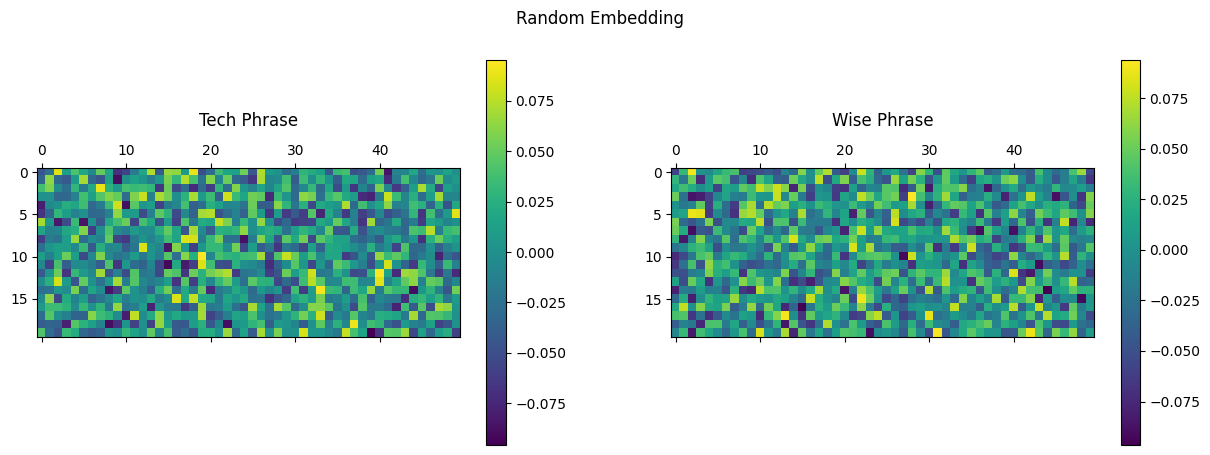

In [16]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

The embedding from the fixed weights layer are visualized below.

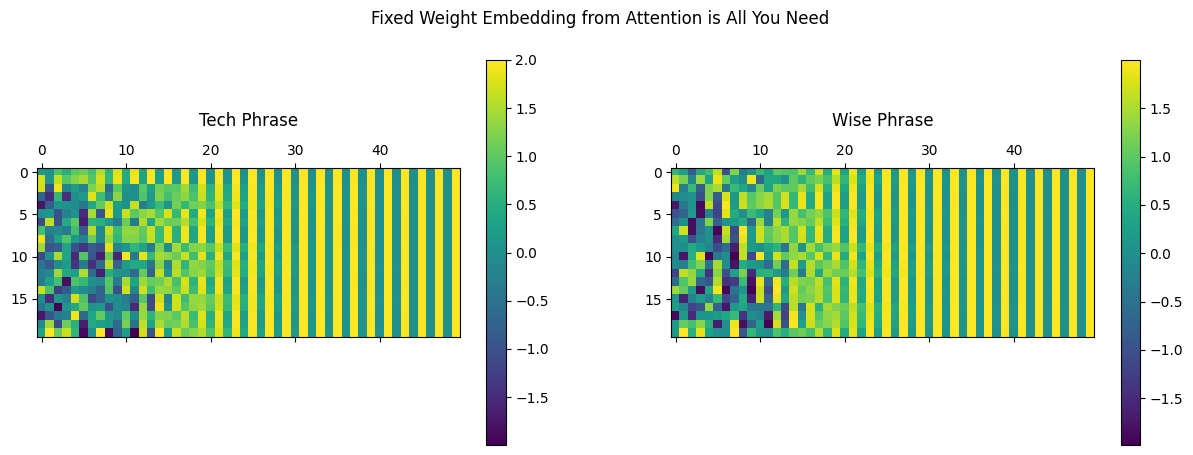

In [17]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()

## Transformer Encoder

References:
- https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras

In [18]:
import tensorflow as tf
# from tensorflow.keras.layers import LayerNormalization, Layer, Dense, ReLU, Dropout, Input
# from multihead_attention import MultiHeadAttention
# from positional_encoding import PositionEmbeddingFixedWeights
 
# Implementing the Add & Norm Layer
class AddNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AddNormalization, self).__init__(**kwargs)
        self.layer_norm = tf.keras.layers.LayerNormalization()  # Layer normalization layer
 
    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x
 
        # Apply layer normalization to the sum
        return self.layer_norm(add)
 
# Implementing the Feed-Forward Layer
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = tf.keras.layers.Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = tf.keras.layers.Dense(d_model)  # Second fully connected layer
        self.activation = tf.keras.layers.ReLU()  # ReLU activation layer
 
    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)
 
        return self.fully_connected2(self.activation(x_fc1))
 
# Implementing the Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.build(input_shape=[None, sequence_length, d_model])
        self.d_model = d_model
        self.sequence_length = sequence_length
        
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.add_norm2 = AddNormalization()
 
    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output = self.multihead_attention(x, x, x, padding_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in a dropout layer
        multihead_output = self.dropout1(multihead_output, training=training)
 
        # Followed by an Add & Norm layer
        addnorm_output = self.add_norm1(x, multihead_output)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in another dropout layer
        feedforward_output = self.dropout2(feedforward_output, training=training)
 
        # Followed by another Add & Norm layer
        return self.add_norm2(addnorm_output, feedforward_output)
      
    def build_graph(self):
        input_layer = tf.keras.layers.Input(shape=(self.sequence_length, self.d_model))
        return tf.keras.Model(inputs=[input_layer], outputs=self.call(input_layer, None, True))
 
# Implementing the Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.encoder_layer = [EncoderLayer(sequence_length, h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
 
    def call(self, input_sentence, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(input_sentence)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)
 
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x = layer(x, padding_mask, training)
 
        return x

#### Testing Out the Code

In [19]:
import numpy as np
# from numpy import random
 
'''
You will work with the parameter values specified in the paper, 
Attention Is All You Need, by Vaswani et al. (2017):
'''
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack
 
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
 
# Dummy Data
enc_vocab_size = 20 # Vocabulary size for the encoder
input_seq_length = 5  # Maximum length of the input sequence
input_seq = np.random.random((batch_size, input_seq_length))
 
encoder = Encoder(enc_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(encoder(input_seq, None, True))

tf.Tensor(
[[[-1.4871118   0.7065537   1.7660948  ...  1.1331463   0.5811005
   -0.48423845]
  [-0.5834078  -0.16482513  1.4892291  ...  0.24964355  0.14173335
   -0.68002784]
  [-0.3036474  -0.19818063  1.473912   ...  0.44230655  0.18741792
   -0.22923476]
  [-1.0219748  -0.24659294  1.2827979  ...  0.27165347  0.05344507
    0.9452918 ]
  [-1.2028902  -0.61199874  1.0358663  ...  0.67940015  0.3353876
   -1.1025178 ]]

 [[-1.0921112   0.7390727   1.5044237  ... -0.25500923  0.53103805
    0.4292648 ]
  [-0.85799     0.25277308  0.88591963 ...  0.14107053 -0.00737675
   -0.19071318]
  [-0.9579819  -0.18286535  1.243855   ...  0.41148475 -0.38286662
   -0.3376076 ]
  [-0.8673387   0.4018647   0.6271574  ...  0.02096778  0.28504393
   -0.4317767 ]
  [-1.5610294  -0.02222542  1.6030173  ... -0.0878982   0.5942195
   -0.28966773]]

 [[-1.3726432   1.4476305   1.506739   ...  0.8129769   0.48946804
   -0.61809534]
  [-0.3423772   0.09857825  0.811228   ... -0.8327967   0.28059474
   -0.83

## Transformer Decoder

https://machinelearningmastery.com/implementing-the-transformer-decoder-from-scratch-in-tensorflow-and-keras

In [20]:
import tensorflow as tf
# from tensorflow.keras.layers import Layer, Dropout, Input
# from multihead_attention import MultiHeadAttention
# from positional_encoding import PositionEmbeddingFixedWeights
# from encoder import AddNormalization, FeedForward
 
# Implementing the Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    # def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
    def __init__(self, sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.build(input_shape=[None, sequence_length, d_model])
        self.sequence_length = sequence_length
        self.d_model = d_model
        self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.multihead_attention2 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.add_norm2 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        self.add_norm3 = AddNormalization()
 
    def call(self, x, encoder_output, lookahead_mask, padding_mask, training):
        # Multi-head attention layer
        multihead_output1 = self.multihead_attention1(x, x, x, lookahead_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in a dropout layer
        multihead_output1 = self.dropout1(multihead_output1, training=training)
 
        # Followed by an Add & Norm layer
        addnorm_output1 = self.add_norm1(x, multihead_output1)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Followed by another multi-head attention layer
        multihead_output2 = self.multihead_attention2(addnorm_output1, encoder_output, encoder_output, padding_mask)
 
        # Add in another dropout layer
        multihead_output2 = self.dropout2(multihead_output2, training=training)
 
        # Followed by another Add & Norm layer
        addnorm_output2 = self.add_norm1(addnorm_output1, multihead_output2)
 
        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output2)
        # Expected output shape = (batch_size, sequence_length, d_model)
 
        # Add in another dropout layer
        feedforward_output = self.dropout3(feedforward_output, training=training)
 
        # Followed by another Add & Norm layer
        return self.add_norm3(addnorm_output2, feedforward_output)

    def build_graph(self):
        input_layer = tf.keras.layers.Input(shape=(self.sequence_length, self.d_model))
        return tf.keras.Model(inputs=[input_layer], outputs=self.call(input_layer, input_layer, None, None, True))
 
# Implementing the Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.decoder_layer = [DecoderLayer(sequence_length, h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
 
    def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training):
        # Generate the positional encoding
        pos_encoding_output = self.pos_encoding(output_target)
        # Expected output shape = (number of sentences, sequence_length, d_model)
 
        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)
 
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.decoder_layer):
            x = layer(x, encoder_output, lookahead_mask, padding_mask, training)
 
        return x

#### Testing Out the Code

In [21]:
import numpy as np
# from numpy import random
 
dec_vocab_size = 20  # Vocabulary size for the decoder
input_seq_length = 5  # Maximum length of the input sequence
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the decoder stack
 
batch_size = 64  # Batch size from the training process
dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers
 
input_seq = np.random.random((batch_size, input_seq_length))
enc_output = np.random.random((batch_size, input_seq_length, d_model))
 
decoder = Decoder(dec_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
print(decoder(input_seq, enc_output, None, True))

tf.Tensor(
[[[-1.2556648   0.5240724   0.45565352 ...  0.12321148 -0.5116821
    0.35534087]
  [-1.1213216   0.43913886  0.54584855 ...  0.11843275 -0.5181516
    0.294182  ]
  [-1.0704263   0.31496334  0.57750046 ...  0.11462958 -0.51452535
    0.25321156]
  [-1.1206017   0.21533681  0.5305978  ...  0.10602295 -0.49268055
    0.25585756]
  [-1.2067827   0.19840121  0.4584211  ...  0.07858987 -0.4461658
    0.29954752]]

 [[-0.8105176   0.38516626  0.80646914 ...  0.06318504 -0.12942152
    0.33833182]
  [-0.6703304   0.30299225  0.90419877 ...  0.07065903 -0.12214505
    0.2960774 ]
  [-0.6253582   0.15751527  0.94208497 ...  0.08409728 -0.10932003
    0.2641535 ]
  [-0.68516845  0.04228818  0.9039742  ...  0.07946574 -0.09798248
    0.24861811]
  [-0.7848989   0.00894842  0.8042033  ...  0.04633076 -0.08237212
    0.27152687]]

 [[-1.3859762   0.3049842   0.7054542  ...  0.38549337 -0.3479813
    0.43987784]
  [-1.2534497   0.23012665  0.8056217  ...  0.36594343 -0.35115722
    0.386

## Merging Transformer Encoder and Decoder

https://machinelearningmastery.com/joining-the-transformer-encoder-and-decoder-and-masking/

In [22]:
import tensorflow as tf
# from encoder import Encoder
# from decoder import Decoder

# from tensorflow import math, cast, float32, linalg, ones, maximum, newaxis
# from tensorflow.keras import Model
# from tensorflow.keras.layers import Dense
 
 
class TransformerModel(tf.keras.Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):
        super(TransformerModel, self).__init__(**kwargs)
 
        # Set up the encoder
        self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)
 
        # Set up the decoder
        self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)
 
        # Define the final dense layer
        self.model_last_layer = tf.keras.layers.Dense(dec_vocab_size)
 
    def padding_mask(self, input):
        # Create mask which marks the zero padding values in the input by a 1.0
        mask = tf.math.equal(input, 0)
        mask = tf.cast(mask, tf.float32)
 
        # The shape of the mask should be broadcastable to the shape
        # of the attention weights that it will be masking later on
        return mask[:, tf.newaxis, tf.newaxis, :]
 
    def lookahead_mask(self, shape):
        # Mask out future entries by marking them with a 1.0
        mask = 1 - tf.linalg.band_part(tf.ones((shape, shape)), -1, 0)
 
        return mask
 
    def call(self, encoder_input, decoder_input, training):
 
        # Create padding mask to mask the encoder inputs and the encoder outputs in the decoder
        enc_padding_mask = self.padding_mask(encoder_input)
 
        # Create and combine padding and look-ahead masks to be fed into the decoder
        dec_in_padding_mask = self.padding_mask(decoder_input)
        dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])
        dec_in_lookahead_mask = tf.maximum(dec_in_padding_mask, dec_in_lookahead_mask)
 
        # Feed the input into the encoder
        encoder_output = self.encoder(encoder_input, enc_padding_mask, training)
 
        # Feed the encoder output into the decoder
        decoder_output = self.decoder(decoder_input, encoder_output, dec_in_lookahead_mask, enc_padding_mask, training)
 
        # Pass the decoder output through a final dense layer
        model_output = self.model_last_layer(decoder_output)
 
        return model_output

In [23]:
enc_vocab_size = 2405 # Vocabulary size for the encoder
dec_vocab_size = 3858 # Vocabulary size for the decoder

enc_seq_length = 5  # Maximum length of the input sequence
dec_seq_length = 5  # Maximum length of the target sequence

h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_ff = 2048  # Dimensionality of the inner fully connected layer
d_model = 512  # Dimensionality of the model sub-layers' outputs
n = 6  # Number of layers in the encoder stack

dropout_rate = 0.1  # Frequency of dropping the input units in the dropout layers

# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

In [24]:
# from encoder import EncoderLayer
# from decoder import DecoderLayer
 
encoder = EncoderLayer(enc_seq_length, h, d_k, d_v, d_model, d_ff, dropout_rate)
encoder.build_graph().summary()
 
decoder = DecoderLayer(dec_seq_length, h, d_k, d_v, d_model, d_ff, dropout_rate)
decoder.build_graph().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 512)]     0           []                               
                                                                                                  
 multi_head_attention_37 (Multi  (None, 5, 512)      131776      ['input_1[0][0]',                
 HeadAttention)                                                   'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 dropout_64 (Dropout)           (None, 5, 512)       0           ['multi_head_attention_37[0][0]']
                                                                                              

## Transformer Training

References:
- https://machinelearningmastery.com/training-the-transformer-model/
https://machinelearningmastery.com/plotting-the-training-and-validation-loss-curves-for-the-transformer-model/

In [25]:
import pickle
import numpy as np
import tensorflow as tf
# from pickle import load, dump, HIGHEST_PROTOCOL
# from numpy.random import shuffle
# from numpy import savetxt
# from keras.preprocessing.text import Tokenizer
# # from keras.preprocessing.sequence import pad_sequences
# from keras.utils import pad_sequences
# from tensorflow import convert_to_tensor, int64
 
class PrepareDataset:
    def __init__(self, **kwargs):
        super(PrepareDataset, self).__init__(**kwargs)
        self.n_sentences = 15000  # Number of sentences to include in the dataset
        self.train_split = 0.8  # Ratio of the training data split
        self.val_split = 0.1  # Ratio of the validation data split
 
    # Fit a tokenizer
    def create_tokenizer(self, dataset):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(dataset)
 
        return tokenizer
 
    def find_seq_length(self, dataset):
        return max(len(seq.split()) for seq in dataset)
 
    def find_vocab_size(self, tokenizer, dataset):
        tokenizer.fit_on_texts(dataset)
 
        return len(tokenizer.word_index) + 1
 
    # Encode and pad the input sequences
    def encode_pad(self, dataset, tokenizer, seq_length):
        x = tokenizer.texts_to_sequences(dataset)
        x = tf.keras.utils.pad_sequences(x, maxlen=seq_length, padding='post')
        x = tf.convert_to_tensor(x, dtype=tf.int64)
 
        return x
 
    def save_tokenizer(self, tokenizer, name):
        with open(name + '_tokenizer.pkl', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
    def __call__(self, filename, **kwargs):
        # Load a clean dataset
        clean_dataset = pickle.load(open(filename, 'rb'))
 
        # Reduce dataset size
        dataset = clean_dataset[:self.n_sentences, :]
 
        # Include start and end of string tokens
        for i in range(dataset[:, 0].size):
            dataset[i, 0] = "<START> " + dataset[i, 0] + " <EOS>"
            dataset[i, 1] = "<START> " + dataset[i, 1] + " <EOS>"
 
        # Random shuffle the dataset
        np.random.shuffle(dataset)
 
        # Split the dataset in training, validation and test sets
        train = dataset[:int(self.n_sentences * self.train_split)]
        val = dataset[int(self.n_sentences * self.train_split):int(self.n_sentences * (1-self.val_split))]
        test = dataset[int(self.n_sentences * (1 - self.val_split)):]
 
        # Prepare tokenizer for the encoder input
        enc_tokenizer = self.create_tokenizer(dataset[:, 0])
        enc_seq_length = self.find_seq_length(dataset[:, 0])
        enc_vocab_size = self.find_vocab_size(enc_tokenizer, train[:, 0])
 
        # Prepare tokenizer for the decoder input
        dec_tokenizer = self.create_tokenizer(dataset[:, 1])
        dec_seq_length = self.find_seq_length(dataset[:, 1])
        dec_vocab_size = self.find_vocab_size(dec_tokenizer, train[:, 1])
 
        # Encode and pad the training input
        trainX = self.encode_pad(train[:, 0], enc_tokenizer, enc_seq_length)
        trainY = self.encode_pad(train[:, 1], dec_tokenizer, dec_seq_length)
 
        # Encode and pad the validation input
        valX = self.encode_pad(val[:, 0], enc_tokenizer, enc_seq_length)
        valY = self.encode_pad(val[:, 1], dec_tokenizer, dec_seq_length)
 
        # Save the encoder tokenizer
        self.save_tokenizer(enc_tokenizer, 'enc')
 
        # Save the decoder tokenizer
        self.save_tokenizer(dec_tokenizer, 'dec')
 
        # Save the testing dataset into a text file
        np.savetxt('test_dataset.txt', test, fmt='%s')
 
        return trainX, trainY, valX, valY, train, val, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size

In [26]:
import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.schedules import LearningRateSchedule
# from tensorflow.keras.metrics import Mean
# from tensorflow import data, train, math, reduce_sum, cast, equal, argmax, float32, GradientTape, function
# from keras.losses import sparse_categorical_crossentropy
# # from model import TransformerModel
# # from prepare_dataset import PrepareDataset

import time
import pickle
# from time import time
# from pickle import dump
 
 
# Define the model parameters
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack
 
# Define the training parameters
epochs = 20
batch_size = 64
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1
 
 
# Implementing a learning rate scheduler
class LRScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, **kwargs):
        super(LRScheduler, self).__init__(**kwargs)
 
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
 
    def __call__(self, step_num):
 
        # Linearly increasing the learning rate for the first warmup_steps, and decreasing it thereafter
        arg1 = step_num ** -0.5
        arg2 = step_num * (self.warmup_steps ** -1.5)
 
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)
 
 
# Instantiate an Adam optimizer
optimizer = tf.keras.optimizers.Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)
 
# Prepare the training dataset
dataset = PrepareDataset()
trainX, trainY, valX, valY, train_orig, val_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset('english-german.pkl')
 
print(enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size)
 
# Prepare the training dataset batches
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_dataset = train_dataset.batch(batch_size)
 
# Prepare the validation dataset batches
val_dataset = tf.data.Dataset.from_tensor_slices((valX, valY))
val_dataset = val_dataset.batch(batch_size)
 
# Create model
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
 
 
# Defining the loss function
def loss_fcn(target, prediction):
    # Create mask so that the zero padding values are not included in the computation of loss
    padding_mask = tf.math.logical_not(tf.equal(target, 0))
    padding_mask = tf.cast(padding_mask, tf.float32)
 
    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = tf.keras.metrics.sparse_categorical_crossentropy(target, prediction, from_logits=True) * padding_mask
 
    # Compute the mean loss over the unmasked values
    return tf.reduce_sum(loss) / tf.reduce_sum(padding_mask)
 
 
# Defining the accuracy function
def accuracy_fcn(target, prediction):
    # Create mask so that the zero padding values are not included in the computation of accuracy
    padding_mask = tf.math.logical_not(tf.equal(target, 0))
 
    # Find equal prediction and target values, and apply the padding mask
    accuracy = tf.equal(target, tf.argmax(prediction, axis=2))
    accuracy = tf.math.logical_and(padding_mask, accuracy)
 
    # Cast the True/False values to 32-bit-precision floating-point numbers
    padding_mask = tf.cast(padding_mask, tf.float32)
    accuracy = tf.cast(accuracy, tf.float32)
 
    # Compute the mean accuracy over the unmasked values
    return tf.reduce_sum(accuracy) / tf.reduce_sum(padding_mask)
 
 
# Include metrics monitoring
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
 
# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = tf.train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=None)
 
# Initialise dictionaries to store the training and validation losses
train_loss_dict = {}
val_loss_dict = {}
 
# Speeding up the training process
@tf.function
def train_step(encoder_input, decoder_input, decoder_output):
    with tf.GradientTape() as tape:
 
        # Run the forward pass of the model to generate a prediction
        prediction = training_model(encoder_input, decoder_input, training=True)
 
        # Compute the training loss
        loss = loss_fcn(decoder_output, prediction)
 
        # Compute the training accuracy
        accuracy = accuracy_fcn(decoder_output, prediction)
 
    # Retrieve gradients of the trainable variables with respect to the training loss
    gradients = tape.gradient(loss, training_model.trainable_weights)
 
    # Update the values of the trainable variables by gradient descent
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))
 
    train_loss(loss)
    train_accuracy(accuracy)
 
 
for epoch in range(epochs):
 
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
 
    print("\nStart of epoch %d" % (epoch + 1))
 
    start_time = time.time()
 
    # Iterate over the dataset batches
    for step, (train_batchX, train_batchY) in enumerate(train_dataset):
 
        # Define the encoder and decoder inputs, and the decoder output
        encoder_input = train_batchX[:, 1:]
        decoder_input = train_batchY[:, :-1]
        decoder_output = train_batchY[:, 1:]
 
        train_step(encoder_input, decoder_input, decoder_output)
 
        if step % 50 == 0:
            print(f'Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
 
    # Run a validation step after every epoch of training
    for val_batchX, val_batchY in val_dataset:
 
        # Define the encoder and decoder inputs, and the decoder output
        encoder_input = val_batchX[:, 1:]
        decoder_input = val_batchY[:, :-1]
        decoder_output = val_batchY[:, 1:]
 
        # Generate a prediction
        prediction = training_model(encoder_input, decoder_input, training=False)
 
        # Compute the validation loss
        loss = loss_fcn(decoder_output, prediction)
        val_loss(loss)
 
    # Print epoch number and accuracy and loss values at the end of every epoch
    print("Epoch %d: Training Loss %.4f, Training Accuracy %.4f, Validation Loss %.4f" % (epoch + 1, train_loss.result(), train_accuracy.result(), val_loss.result()))
 
    # Save a checkpoint after every epoch
    if (epoch + 1) % 1 == 0:
 
        save_path = ckpt_manager.save()
        print("Saved checkpoint at epoch %d" % (epoch + 1))
 
        # Save the trained model weights
        training_model.save_weights("weights/wghts" + str(epoch + 1) + ".ckpt")
 
        train_loss_dict[epoch] = train_loss.result()
        val_loss_dict[epoch] = val_loss.result()
 
# Save the training loss values
with open('./train_loss.pkl', 'wb') as file:
    pickle.dump(train_loss_dict, file)
 
# Save the validation loss values
with open('./val_loss.pkl', 'wb') as file:
    pickle.dump(val_loss_dict, file)
 
print("Total time taken: %.2fs" % (time.time() - start_time))

8 12 3167 5065

Start of epoch 1
Epoch 1 Step 0 Loss 8.6665 Accuracy 0.0033
Epoch 1 Step 50 Loss 7.9778 Accuracy 0.1309
Epoch 1 Step 100 Loss 7.3964 Accuracy 0.1711
Epoch 1 Step 150 Loss 7.0080 Accuracy 0.1898
Epoch 1: Training Loss 6.7642, Training Accuracy 0.2027, Validation Loss 5.5930
Saved checkpoint at epoch 1

Start of epoch 2
Epoch 2 Step 0 Loss 5.6477 Accuracy 0.2575
Epoch 2 Step 50 Loss 5.4198 Accuracy 0.2705
Epoch 2 Step 100 Loss 5.2605 Accuracy 0.2759
Epoch 2 Step 150 Loss 5.1160 Accuracy 0.2845
Epoch 2: Training Loss 5.0304, Training Accuracy 0.2910, Validation Loss 4.6085
Saved checkpoint at epoch 2

Start of epoch 3
Epoch 3 Step 0 Loss 4.6563 Accuracy 0.3378
Epoch 3 Step 50 Loss 4.5045 Accuracy 0.3446
Epoch 3 Step 100 Loss 4.4283 Accuracy 0.3549
Epoch 3 Step 150 Loss 4.3424 Accuracy 0.3650
Epoch 3: Training Loss 4.2897, Training Accuracy 0.3704, Validation Loss 4.0977
Saved checkpoint at epoch 3

Start of epoch 4
Epoch 4 Step 0 Loss 4.1365 Accuracy 0.4147
Epoch 4 Step 50

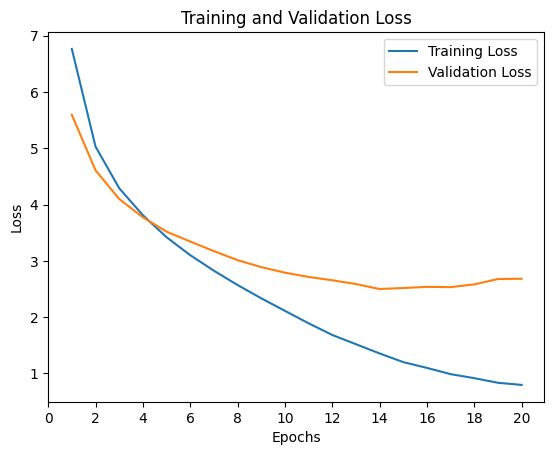

In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
# from pickle import load
# from matplotlib.pylab import plt
# from numpy import arange
 
# Load the training and validation loss dictionaries
train_loss = pickle.load(open('train_loss.pkl', 'rb'))
val_loss = pickle.load(open('val_loss.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_values = list(train_loss.values())
val_values = list(val_loss.values())
 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 21)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

## Inference

References:
- https://machinelearningmastery.com/inferencing-the-transformer-model/

In [28]:
import tensorflow as tf
# from pickle import load
# from tensorflow import Module
# # from keras.preprocessing.sequence import pad_sequences
# from keras.utils import pad_sequences
# from tensorflow import convert_to_tensor, int64, TensorArray, argmax, newaxis, transpose
# # from model import TransformerModel

# Define the model parameters
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

# Define the dataset parameters
enc_seq_length = 8  # Encoder sequence length
dec_seq_length = 12  # Decoder sequence length
enc_vocab_size = 3167  # Encoder vocabulary size
dec_vocab_size = 5065  # Decoder vocabulary size

# Create model
inferencing_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, 0)


class Translate(tf.Module):
    def __init__(self, inferencing_model, **kwargs):
        super(Translate, self).__init__(**kwargs)
        self.transformer = inferencing_model

    def load_tokenizer(self, name):
        with open(name, 'rb') as handle:
            return pickle.load(handle)

    def __call__(self, sentence):
        # Append start and end of string tokens to the input sentence
        sentence[0] = "<START> " + sentence[0] + " <EOS>"

        # Load encoder and decoder tokenizers
        enc_tokenizer = self.load_tokenizer('enc_tokenizer.pkl')
        dec_tokenizer = self.load_tokenizer('dec_tokenizer.pkl')

        # Prepare the input sentence by tokenizing, padding and converting to tensor
        encoder_input = enc_tokenizer.texts_to_sequences(sentence)
        encoder_input = tf.keras.utils.pad_sequences(encoder_input, maxlen=enc_seq_length, padding='post')
        encoder_input = tf.convert_to_tensor(encoder_input, dtype=tf.int64)

        # Prepare the output <START> token by tokenizing, and converting to tensor
        output_start = dec_tokenizer.texts_to_sequences(["<START>"])
        output_start = tf.convert_to_tensor(output_start[0], dtype=tf.int64)

        # Prepare the output <EOS> token by tokenizing, and converting to tensor
        output_end = dec_tokenizer.texts_to_sequences(["<EOS>"])
        output_end = tf.convert_to_tensor(output_end[0], dtype=tf.int64)

        # Prepare the output array of dynamic size
        decoder_output = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        decoder_output = decoder_output.write(0, output_start)

        for i in range(dec_seq_length):

            # Predict an output token
            prediction = self.transformer(encoder_input, tf.transpose(decoder_output.stack()), training=False)

            prediction = prediction[:, -1, :]

            # Select the prediction with the highest score
            predicted_id = tf.argmax(prediction, axis=-1)
            predicted_id = predicted_id[0][tf.newaxis]

            # Write the selected prediction to the output array at the next available index
            decoder_output = decoder_output.write(i + 1, predicted_id)

            # Break if an <EOS> token is predicted
            if predicted_id == output_end:
                break

        output = tf.transpose(decoder_output.stack())[0]
        output = output.numpy()

        output_str = []

        # Decode the predicted tokens into an output string
        for i in range(output.shape[0]):

            key = output[i]
            print(dec_tokenizer.index_word[key])

        return output_str

### Testing Out the Code

In [29]:
# Sentence to translate
sentence = ['im thirsty']

# Load the trained model's weights at the specified epoch
inferencing_model.load_weights('weights/wghts16.ckpt')
 
# Create a new instance of the 'Translate' class
translator = Translate(inferencing_model)
 
# Translate the input sentence
print(translator(sentence))

start
fangen
sie
mir
eos
[]


## Dependencies

In [30]:
!pip install session-info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 9.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=137e5623867d55eaf42fe3d72c1219781912b62ddbb80561b8a75f15d06af685
  Stored in directory: /root/.cache/pip/wheels/d4/fc/2e/00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info


In [31]:
import session_info

session_info.show()